In [1]:
!nvidia-smi

Mon Sep 26 12:56:21 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P8    11W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
path="/content/drive/MyDrive/Code/ViT-pytorch-main"
os.chdir(path)
os.listdir(path)

['LICENSE',
 '.gitignore',
 'visualize_attention_map.ipynb',
 'requirements.txt',
 'README.md',
 '.ipynb_checkpoints',
 'data',
 'models',
 'checkpoint',
 'output',
 'utils',
 'logs',
 'img',
 'setup.sh',
 'apex',
 'ViT-B_16.ipynb',
 'ngrok-stable-linux-amd64.zip',
 'ngrok',
 'ngrok-stable-linux-amd64.zip.1',
 'ngrok-stable-linux-amd64.zip.2',
 'ViT-B_16-224.ipynb',
 'ngrok-stable-linux-amd64.zip.3']

In [4]:
# !git clone https://github.com/NVIDIA/apex
%cd apex
!python3 setup.py install

/content/drive/MyDrive/Code/ViT-pytorch-main/apex


torch.__version__  = 1.12.1+cu113


running install
running bdist_egg
running egg_info
writing apex.egg-info/PKG-INFO
writing dependency_links to apex.egg-info/dependency_links.txt
writing top-level names to apex.egg-info/top_level.txt
adding license file 'LICENSE'
writing manifest file 'apex.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/apex
copying build/lib/apex/__init__.py -> build/bdist.linux-x86_64/egg/apex
copying build/lib/apex/_autocast_utils.py -> build/bdist.linux-x86_64/egg/apex
creating build/bdist.linux-x86_64/egg/apex/RNN
copying build/lib/apex/RNN/__init__.py -> build/bdist.linux-x86_64/egg/apex/RNN
copying build/lib/apex/RNN/RNNBackend.py -> build/bdist.linux-x86_64/egg/apex/RNN
copying build/lib/apex/RNN/models.py -> build/bdist.linux-x86_64/egg/apex/RNN
copying build/lib/ap

In [5]:
!pip install -qr /content/drive/MyDrive/Code/ViT-pytorch-main/requirements.txt

In [6]:
import os
path="/content/drive/MyDrive/Code/ViT-pytorch-main"
os.chdir(path)
os.listdir(path)

['LICENSE',
 '.gitignore',
 'visualize_attention_map.ipynb',
 'requirements.txt',
 'README.md',
 '.ipynb_checkpoints',
 'data',
 'models',
 'checkpoint',
 'output',
 'utils',
 'logs',
 'img',
 'setup.sh',
 'apex',
 'ViT-B_16.ipynb',
 'ngrok-stable-linux-amd64.zip',
 'ngrok',
 'ngrok-stable-linux-amd64.zip.1',
 'ngrok-stable-linux-amd64.zip.2',
 'ViT-B_16-224.ipynb',
 'ngrok-stable-linux-amd64.zip.3']

In [7]:
# coding=utf-8
from __future__ import absolute_import, division, print_function

import logging
import argparse
import os
import random
import numpy as np

from datetime import timedelta

import torch
import torch.distributed as dist

from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
from apex import amp
from apex.parallel import DistributedDataParallel as DDP

from models.modeling import VisionTransformer, CONFIGS
from utils.scheduler import WarmupLinearSchedule, WarmupCosineSchedule
from utils.data_utils import get_loader
from utils.dist_util import get_world_size
import sys
sys.argv = ['train.py']

In [8]:
logger = logging.getLogger(__name__)

In [9]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [10]:
def simple_accuracy(preds, labels):
    return (preds == labels).mean()

In [11]:
def save_model(args, model):
    model_to_save = model.module if hasattr(model, 'module') else model
    model_checkpoint = os.path.join(args.output_dir, "%s_checkpoint.bin" % args.name)
    torch.save(model_to_save.state_dict(), model_checkpoint)
    logger.info("Saved model checkpoint to [DIR: %s]", args.output_dir)

In [12]:
def setup(args):
    # Prepare model
    config = CONFIGS[args.model_type]

    num_classes = 10 if args.dataset == "cifar10" else 100

    model = VisionTransformer(config, args.img_size, zero_head=True, num_classes=num_classes)
    model.load_from(np.load(args.pretrained_dir))
    model.to(args.device)
    num_params = count_parameters(model)

    logger.info("{}".format(config))
    logger.info("Training parameters %s", args)
    logger.info("Total Parameter: \t%2.1fM" % num_params)
    print(num_params)
    return args, model

In [13]:
def count_parameters(model):
    params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return params/1000000

In [14]:
def set_seed(args):
    random.seed(args.seed)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    if args.n_gpu > 0:
        torch.cuda.manual_seed_all(args.seed)

In [15]:
def valid(args, model, writer, test_loader, global_step):
    # Validation!
    eval_losses = AverageMeter()

    logger.info("***** Running Validation *****")
    logger.info("  Num steps = %d", len(test_loader))
    logger.info("  Batch size = %d", args.eval_batch_size)

    model.eval()
    all_preds, all_label = [], []
    epoch_iterator = tqdm(test_loader,
                          desc="Validating... (loss=X.X)",
                          bar_format="{l_bar}{r_bar}",
                          dynamic_ncols=True,
                          disable=args.local_rank not in [-1, 0])
    loss_fct = torch.nn.CrossEntropyLoss()
    for step, batch in enumerate(epoch_iterator):
        batch = tuple(t.to(args.device) for t in batch)
        x, y = batch
        with torch.no_grad():
            logits = model(x)[0]

            eval_loss = loss_fct(logits, y)
            eval_losses.update(eval_loss.item())

            preds = torch.argmax(logits, dim=-1)

        if len(all_preds) == 0:
            all_preds.append(preds.detach().cpu().numpy())
            all_label.append(y.detach().cpu().numpy())
        else:
            all_preds[0] = np.append(
                all_preds[0], preds.detach().cpu().numpy(), axis=0
            )
            all_label[0] = np.append(
                all_label[0], y.detach().cpu().numpy(), axis=0
            )
        epoch_iterator.set_description("Validating... (loss=%2.5f)" % eval_losses.val)

    all_preds, all_label = all_preds[0], all_label[0]
    accuracy = simple_accuracy(all_preds, all_label)

    logger.info("\n")
    logger.info("Validation Results")
    logger.info("Global Steps: %d" % global_step)
    logger.info("Valid Loss: %2.5f" % eval_losses.avg)
    logger.info("Valid Accuracy: %2.5f" % accuracy)

    writer.add_scalar("test/accuracy", scalar_value=accuracy, global_step=global_step)
    return accuracy

In [16]:
def train(args, model):
    """ Train the model """
    if args.local_rank in [-1, 0]:
        os.makedirs(args.output_dir, exist_ok=True)
        writer = SummaryWriter(log_dir=os.path.join("logs", args.name))

    args.train_batch_size = args.train_batch_size // args.gradient_accumulation_steps

    # Prepare dataset
    train_loader, test_loader = get_loader(args)

    # Prepare optimizer and scheduler
    optimizer = torch.optim.SGD(model.parameters(),
                                lr=args.learning_rate,
                                momentum=0.9,
                                weight_decay=args.weight_decay)
    t_total = args.num_steps
    if args.decay_type == "cosine":
        scheduler = WarmupCosineSchedule(optimizer, warmup_steps=args.warmup_steps, t_total=t_total)
    else:
        scheduler = WarmupLinearSchedule(optimizer, warmup_steps=args.warmup_steps, t_total=t_total)

    if args.fp16:
        model, optimizer = amp.initialize(models=model,
                                          optimizers=optimizer,
                                          opt_level=args.fp16_opt_level)
        amp._amp_state.loss_scalers[0]._loss_scale = 2**20

    # Distributed training
    if args.local_rank != -1:
        model = DDP(model, message_size=250000000, gradient_predivide_factor=get_world_size())

    # Train!
    logger.info("***** Running training *****")
    logger.info("  Total optimization steps = %d", args.num_steps)
    logger.info("  Instantaneous batch size per GPU = %d", args.train_batch_size)
    logger.info("  Total train batch size (w. parallel, distributed & accumulation) = %d",
                args.train_batch_size * args.gradient_accumulation_steps * (
                    torch.distributed.get_world_size() if args.local_rank != -1 else 1))
    logger.info("  Gradient Accumulation steps = %d", args.gradient_accumulation_steps)

    model.zero_grad()
    set_seed(args)  # Added here for reproducibility (even between python 2 and 3)
    losses = AverageMeter()
    global_step, best_acc = 0, 0
    while True:
        model.train()
        epoch_iterator = tqdm(train_loader,
                              desc="Training (X / X Steps) (loss=X.X)",
                              bar_format="{l_bar}{r_bar}",
                              dynamic_ncols=True,
                              disable=args.local_rank not in [-1, 0])                    
        for step, batch in enumerate(epoch_iterator):
            batch = tuple(t.to(args.device) for t in batch)
            x, y = batch
            loss = model(x, y)

            if args.gradient_accumulation_steps > 1:
                loss = loss / args.gradient_accumulation_steps
            if args.fp16:
                with amp.scale_loss(loss, optimizer) as scaled_loss:
                    scaled_loss.backward()
            else:
                loss.backward()

            # if (step + 1) % args.gradient_accumulation_steps == 0:
            if step % args.gradient_accumulation_steps == 0:
                losses.update(loss.item()*args.gradient_accumulation_steps)
                if args.fp16:
                    torch.nn.utils.clip_grad_norm_(amp.master_params(optimizer), args.max_grad_norm)
                else:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), args.max_grad_norm)
                scheduler.step()
                optimizer.step()
                optimizer.zero_grad()
                global_step += 1

                epoch_iterator.set_description(
                    "Training (%d / %d Steps) (loss=%2.5f)" % (global_step, t_total, losses.val)
                )
                if args.local_rank in [-1, 0]:
                    writer.add_scalar("train/loss", scalar_value=losses.val, global_step=global_step)
                    writer.add_scalar("train/lr", scalar_value=scheduler.get_lr()[0], global_step=global_step)
                if global_step % args.eval_every == 0 and args.local_rank in [-1, 0]:
                    accuracy = valid(args, model, writer, test_loader, global_step)
                    if best_acc < accuracy:
                        save_model(args, model)
                        best_acc = accuracy
                    model.train()

                if global_step % t_total == 0:
                    break
        losses.reset()
        if global_step % t_total == 0:
            break

    if args.local_rank in [-1, 0]:
        writer.close()
    logger.info("Best Accuracy: \t%f" % best_acc)
    logger.info("End Training!")


In [17]:
def main():
    parser = argparse.ArgumentParser()
    # Required parameters
    # parser.add_argument("--name", required=True, default="ants-bees",
    #                     help="Name of this run. Used for monitoring.")
    parser.add_argument("--name", default="ants-bees",
                        help="Name of this run. Used for monitoring.")
    parser.add_argument("--dataset", choices=["cifar10", "cifar100"], default="ants-bees",
                        help="Which downstream task.")
    parser.add_argument("--model_type", choices=["ViT-B_16", "ViT-B_32", "ViT-L_16",
                                                 "ViT-L_32", "ViT-H_14", "R50-ViT-B_16"],
                        default="ViT-B_16",
                        help="Which variant to use.")
    parser.add_argument("--pretrained_dir", type=str, default="/content/drive/MyDrive/Code/ViT-pytorch-main/checkpoint/ViT-B_16.npz",
                        help="Where to search for pretrained ViT models.")
    parser.add_argument("--output_dir", default="output", type=str,
                        help="The output directory where checkpoints will be written.")

    parser.add_argument("--img_size", default=224, type=int,
                        help="Resolution size")
    parser.add_argument("--train_batch_size", default=512, type=int,
                        help="Total batch size for training.")
    parser.add_argument("--eval_batch_size", default=64, type=int,
                        help="Total batch size for eval.")
    parser.add_argument("--eval_every", default=50, type=int,
                        help="Run prediction on validation set every so many steps."
                             "Will always run one evaluation at the end of training.")

    parser.add_argument("--learning_rate", default=3e-2, type=float,
                        help="The initial learning rate for SGD.")
    parser.add_argument("--weight_decay", default=0, type=float,
                        help="Weight deay if we apply some.")
    parser.add_argument("--num_steps", default=1000, type=int,
                        help="Total number of training epochs to perform.")
    parser.add_argument("--decay_type", choices=["cosine", "linear"], default="cosine",
                        help="How to decay the learning rate.")
    parser.add_argument("--warmup_steps", default=100, type=int,
                        help="Step of training to perform learning rate warmup for.")
    parser.add_argument("--max_grad_norm", default=1.0, type=float,
                        help="Max gradient norm.")

    parser.add_argument("--local_rank", type=int, default=-1,
                        help="local_rank for distributed training on gpus")
    parser.add_argument('--seed', type=int, default=42,
                        help="random seed for initialization")
    parser.add_argument('--gradient_accumulation_steps', type=int, default=30,
                        help="Number of updates steps to accumulate before performing a backward/update pass.")
    parser.add_argument('--fp16', action='store_true',
                        help="Whether to use 16-bit float precision instead of 32-bit")
    parser.add_argument('--fp16_opt_level', type=str, default='O2',
                        help="For fp16: Apex AMP optimization level selected in ['O0', 'O1', 'O2', and 'O3']."
                             "See details at https://nvidia.github.io/apex/amp.html")
    parser.add_argument('--loss_scale', type=float, default=0,
                        help="Loss scaling to improve fp16 numeric stability. Only used when fp16 set to True.\n"
                             "0 (default value): dynamic loss scaling.\n"
                             "Positive power of 2: static loss scaling value.\n")
    args = parser.parse_args()

    # Setup CUDA, GPU & distributed training
    if args.local_rank == -1:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        args.n_gpu = torch.cuda.device_count()
    else:  # Initializes the distributed backend which will take care of sychronizing nodes/GPUs
        torch.cuda.set_device(args.local_rank)
        device = torch.device("cuda", args.local_rank)
        torch.distributed.init_process_group(backend='nccl',
                                             timeout=timedelta(minutes=60))
        args.n_gpu = 1
    args.device = device

    # Setup logging
    logging.basicConfig(format='%(asctime)s - %(levelname)s - %(name)s - %(message)s',
                        datefmt='%m/%d/%Y %H:%M:%S',
                        level=logging.INFO if args.local_rank in [-1, 0] else logging.WARN)
    logger.warning("Process rank: %s, device: %s, n_gpu: %s, distributed training: %s, 16-bits training: %s" %
                   (args.local_rank, args.device, args.n_gpu, bool(args.local_rank != -1), args.fp16))

    # Set seed
    set_seed(args)

    # Model & Tokenizer Setup
    args, model = setup(args)

    # Training
    train(args, model)

Download and unzip [ngrok](https://ngrok.com).

<!doctype html><meta name="tb-relative-root" content="./"><!doctype html><!--
@license
Copyright 2019 The TensorFlow Authors. All Rights Reserved.

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
--><html><head><meta charset="utf-8">
<title>TensorBoard</title>
<link rel="shortcut icon" href="">
<link rel="apple-touch-icon" href="">

<style>
@font-face {
  font-family: 'Roboto';
  font-style: normal;
  font-weight: 400;
  src: local('Roboto'), local('Roboto-Regular'), url(/font-roboto/uYECMKoHcO9x1wdmbyHIm3-_kf6ByYO6CLY
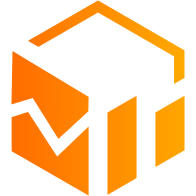
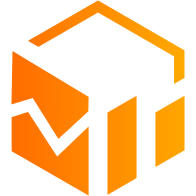

In [18]:
# Get TensorBoard running in the background. 
LOG_DIR = '/content/drive/MyDrive/Code/ViT-pytorch-main/logs/ants-bees'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

# Make sure we're able to connect to the TensorBoard service.
! curl http://localhost:6006

In [19]:
# Download and unzip
! wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip > /dev/null 2>&1
! unzip ngrok-stable-linux-amd64.zip > /dev/null 2>&1

# Launch ngrok background process and retrieve public url.
get_ipython().system_raw('./ngrok http 6006 &')

! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://5797-34-126-159-171.ngrok.io


In [20]:
if __name__ == "__main__":
    main()

85.875556
my data!
{'ants': 0, 'bees': 1}
244
****************************************************************************************************
153


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Training (X / X Steps) (loss=X.X):   0%|| 0/15 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.